In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/ML/Projeto Final/

depre = pd.read_csv('Depression Student Dataset.csv')
depre.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/ML/Projeto Final


,Gender,Age,Academic Pressure,Study Satisfaction,Sleep Duration,Dietary Habits,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,28,2.0,4.0,7-8 hours,Moderate,Yes,9,2,Yes,No
1,Male,28,4.0,5.0,5-6 hours,Healthy,Yes,7,1,Yes,No
2,Male,25,1.0,3.0,5-6 hours,Unhealthy,Yes,10,4,No,Yes
3,Male,23,1.0,4.0,More than 8 hours,Unhealthy,Yes,7,2,Yes,No
4,Female,31,1.0,5.0,More than 8 hours,Healthy,Yes,4,2,Yes,No


**Informações das features e verificação de dados faltantes**

In [78]:
depre.info()
print()
print('Dados Faltantes')
depre.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 502 non-null    object 
 1   Age                                    502 non-null    int64  
 2   Academic Pressure                      502 non-null    float64
 3   Study Satisfaction                     502 non-null    float64
 4   Sleep Duration                         502 non-null    object 
 5   Dietary Habits                         502 non-null    object 
 6   Have you ever had suicidal thoughts ?  502 non-null    object 
 7   Study Hours                            502 non-null    int64  
 8   Financial Stress                       502 non-null    int64  
 9   Family History of Mental Illness       502 non-null    object 
 10  Depression                             502 non-null    object 
dtypes: flo

,0
Gender,0
Age,0
Academic Pressure,0
Study Satisfaction,0
Sleep Duration,0
Dietary Habits,0
Have you ever had suicidal thoughts ?,0
Study Hours,0
Financial Stress,0
Family History of Mental Illness,0


**Distribuição da classe Depression**

Depression
Yes    252
No     250
Name: count, dtype: int64



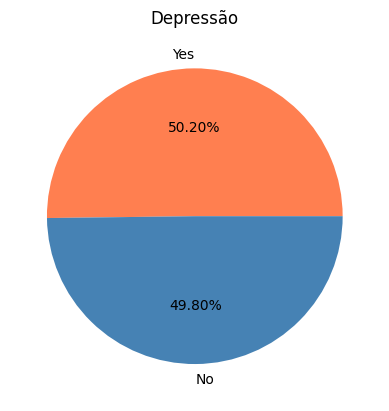

In [79]:
print(depre['Depression'].value_counts())
print()

depre['Depression'].value_counts().plot(kind='pie', autopct='%.2f%%', colors=['coral', 'steelblue'])
plt.title('Depressão')
plt.ylabel('')
plt.show()

In [80]:
numericas = ['Age', 'Academic Pressure', 'Study Satisfaction', 'Study Hours', 'Financial Stress']
categoricas = ['Gender', 'Sleep Duration', 'Dietary Habits',
               'Have you ever had suicidal thoughts ?',
               'Family History of Mental Illness']

**EDA Univariada**

<ipython-input-81-8c62a57601d7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


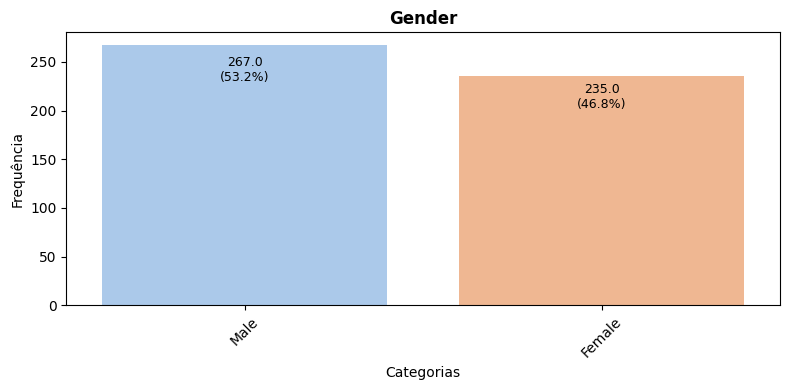

<ipython-input-81-8c62a57601d7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


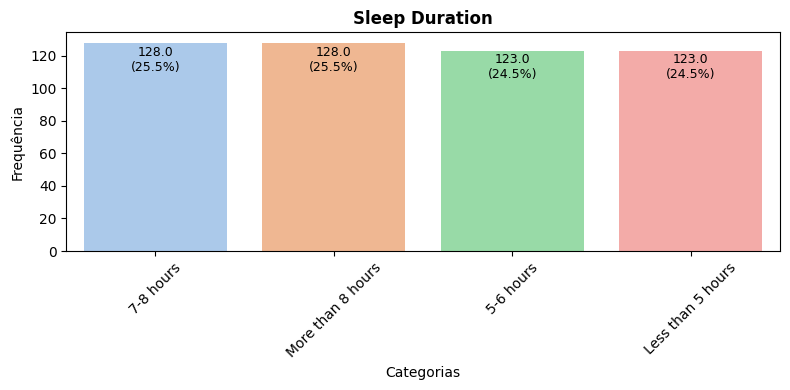

<ipython-input-81-8c62a57601d7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


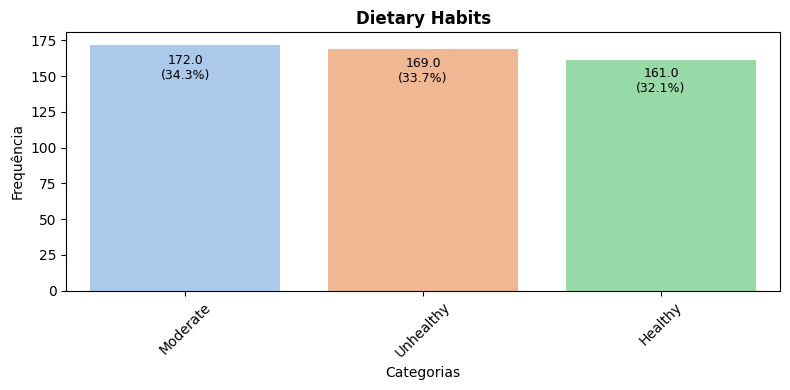

<ipython-input-81-8c62a57601d7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


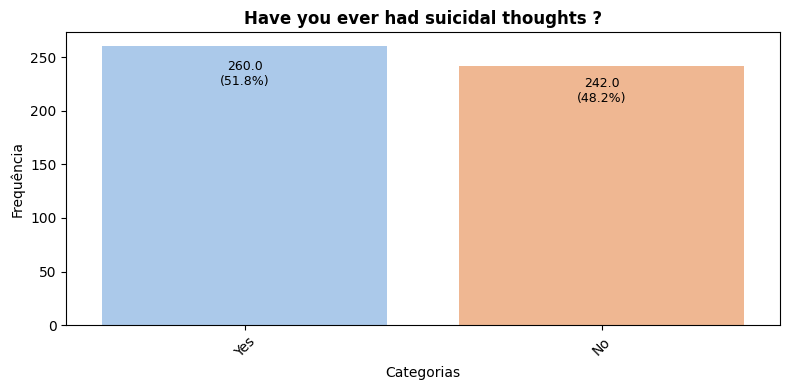

<ipython-input-81-8c62a57601d7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


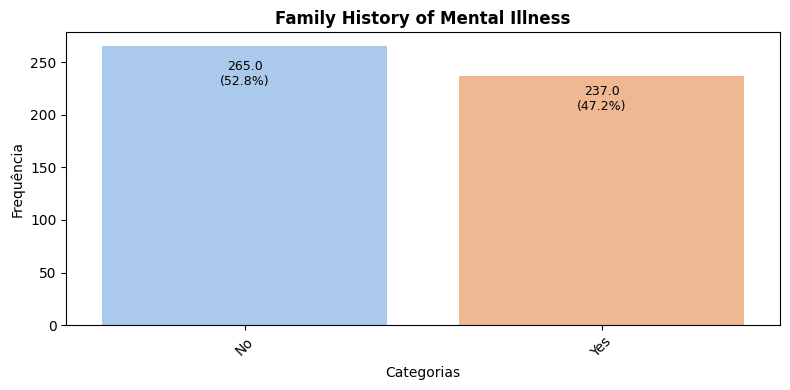

In [81]:
for coluna in categoricas:
    plt.figure(figsize=(8, 4)) # Cria figura para cada gráfico

    ax = sns.countplot(
        x=depre[coluna],
        palette='pastel',  # Paleta suave
        order=depre[coluna].value_counts().index  # Ordena pela frequência
    )

    plt.title(coluna, fontweight='bold')
    plt.xlabel('Categorias')
    plt.ylabel('Frequência')

    # Adiciona porcentagens nas barras
    total = len(depre[coluna])
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width()/2.,       # Posição X do texto
            y=height - (0.15 * height),           # Posição Y do texto
            s=f'{height}\n({height/total:.1%})',
            ha='center',
            va='bottom',
            fontsize=9
        )

    # Ajusta layout
    plt.xticks(rotation=45)  # Rotaciona labels longos
    plt.tight_layout() #
    plt.show()
    print('\n\n')

In [82]:
depre[numericas].describe()

,Age,Academic Pressure,Study Satisfaction,Study Hours,Financial Stress
count,502.000000,502.000000,502.000000,502.000000,502.000000
mean,26.241036,3.003984,3.075697,6.404382,2.928287
std,4.896501,1.390007,1.373490,3.742434,1.425053
min,18.000000,1.000000,1.000000,0.000000,1.000000
25%,22.000000,2.000000,2.000000,3.000000,2.000000
50%,26.500000,3.000000,3.000000,7.000000,3.000000
75%,30.000000,4.000000,4.000000,10.000000,4.000000
max,34.000000,5.000000,5.000000,12.000000,5.000000


In [83]:
# Label encoding
depre['Depression'] = depre['Depression'].replace('No',False)
depre['Depression'] = depre['Depression'].replace('Yes',True)
depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('No',False)
depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('Yes',True)
depre['Family History of Mental Illness'] = depre['Family History of Mental Illness'].replace('No',False)
depre['Family History of Mental Illness'] = depre['Family History of Mental Illness'].replace('Yes',True)

# Convertendo float pra int nas numéricas ordinais
depre['Academic Pressure'] = depre['Academic Pressure'].astype(int)
depre['Study Satisfaction'] = depre['Study Satisfaction'].astype(int)

# One-hot encoding
depre = pd.get_dummies(depre, columns=['Gender', 'Sleep Duration', 'Dietary Habits'])

depre.head()

<ipython-input-83-8cc1f87f1879>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  depre['Depression'] = depre['Depression'].replace('Yes',True)
<ipython-input-83-8cc1f87f1879>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  depre['Have you ever had suicidal thoughts ?'] = depre['Have you ever had suicidal thoughts ?'].replace('Yes',True)
<ipython-input-83-8cc1f87f1879>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer

,Age,Academic Pressure,Study Satisfaction,Have you ever had suicidal thoughts ?,Study Hours,Financial Stress,Family History of Mental Illness,Depression,Gender_Female,Gender_Male,Sleep Duration_5-6 hours,Sleep Duration_7-8 hours,Sleep Duration_Less than 5 hours,Sleep Duration_More than 8 hours,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Unhealthy
0,28,2,4,True,9,2,True,False,False,True,False,True,False,False,False,True,False
1,28,4,5,True,7,1,True,False,False,True,True,False,False,False,True,False,False
2,25,1,3,True,10,4,False,True,False,True,True,False,False,False,False,False,True
3,23,1,4,True,7,2,True,False,False,True,False,False,False,True,False,False,True
4,31,1,5,True,4,2,True,False,True,False,False,False,False,True,True,False,False


In [84]:
X = depre.drop('Depression', axis=1)
y = depre['Depression']

**Histograma**

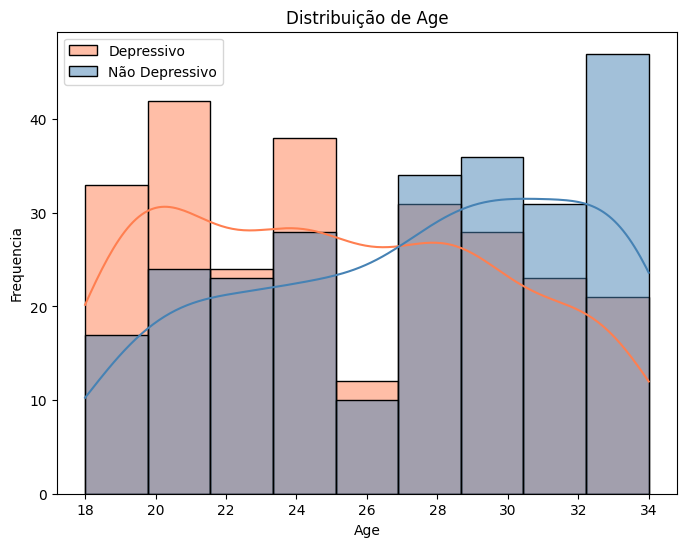

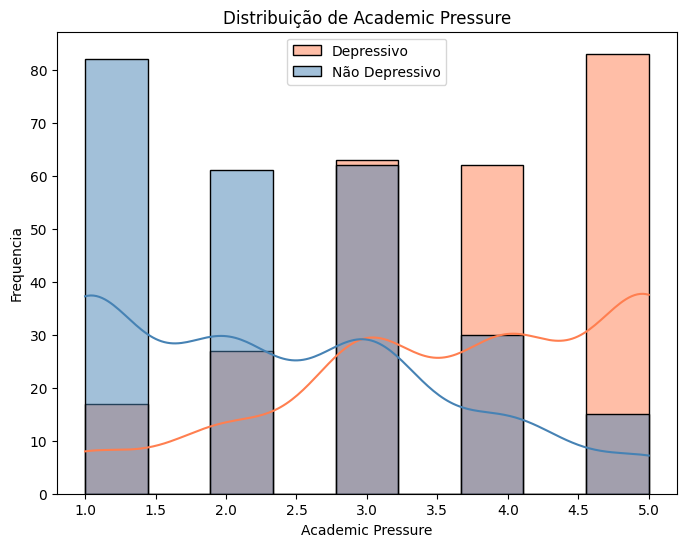

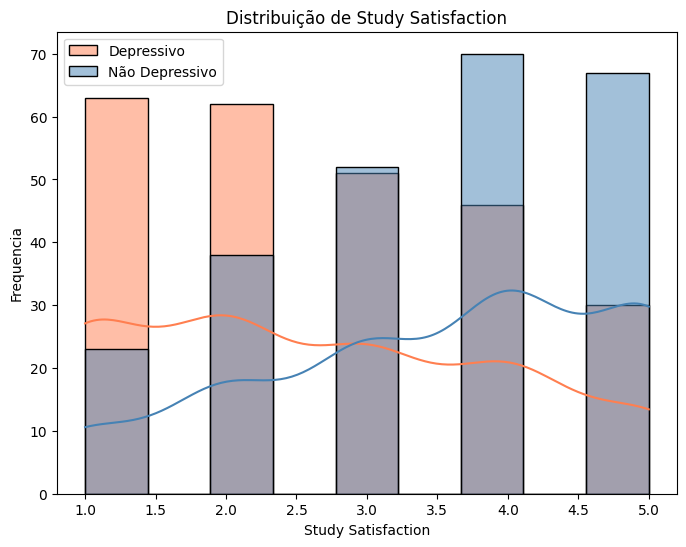

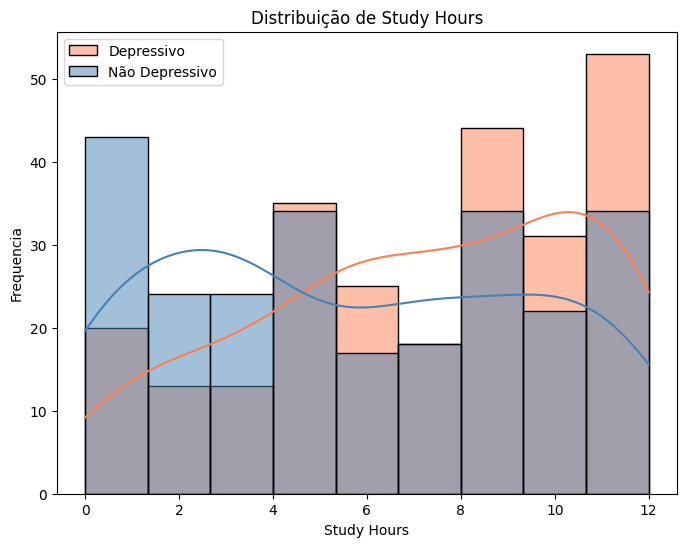

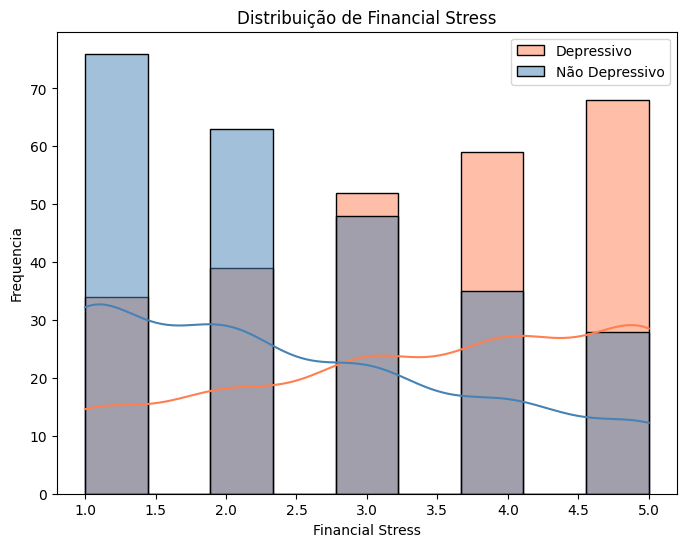

In [85]:
for coluna in numericas:
  plt.figure(figsize=(8, 6))
  sns.histplot(X[y == True][coluna], kde=True, label='Depressivo', color='coral')
  sns.histplot(X[y == False][coluna], kde=True, label='Não Depressivo', color='steelblue')
  plt.xlabel(coluna)
  plt.ylabel('Frequencia')
  plt.title(f'Distribuição de {coluna}')
  plt.legend()
  plt.show()
  print('\n\n')

**EDA Multivariada**

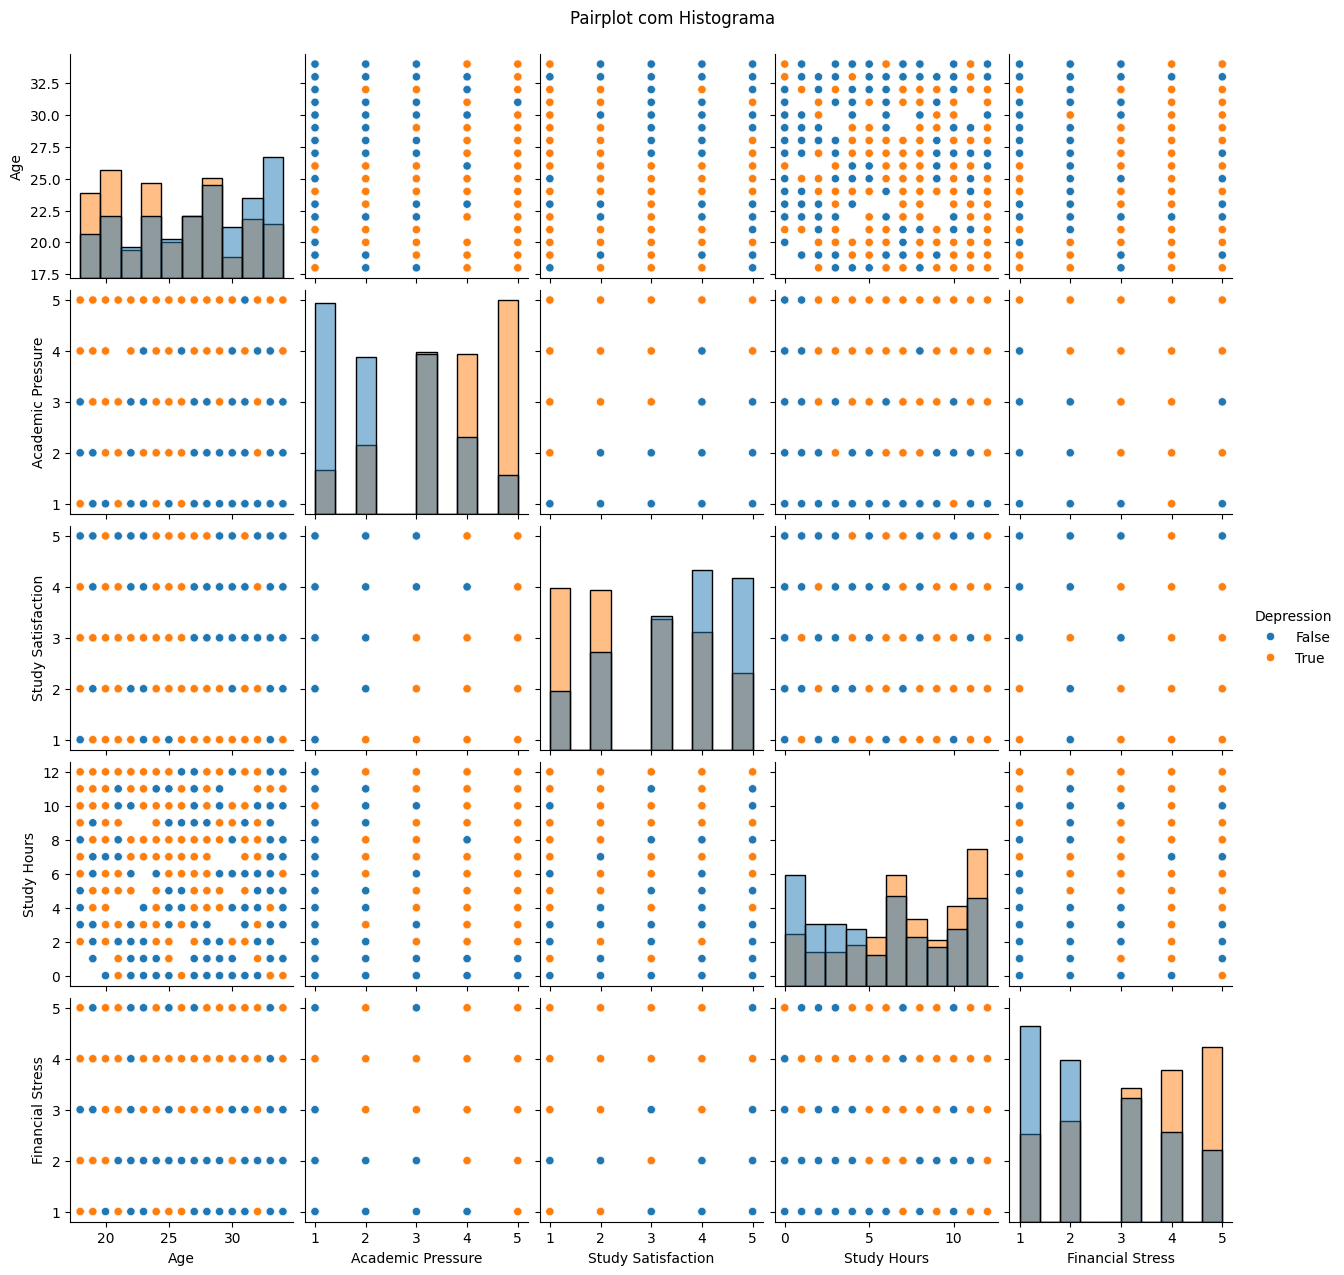

In [86]:
pp_hist = sns.pairplot(
    depre,
    vars=X[numericas],
    hue='Depression',
    diag_kind='hist'
)
plt.suptitle('Pairplot com Histograma', y=1.02)
plt.savefig('pairplot_hist.png', bbox_inches='tight')
plt.show()

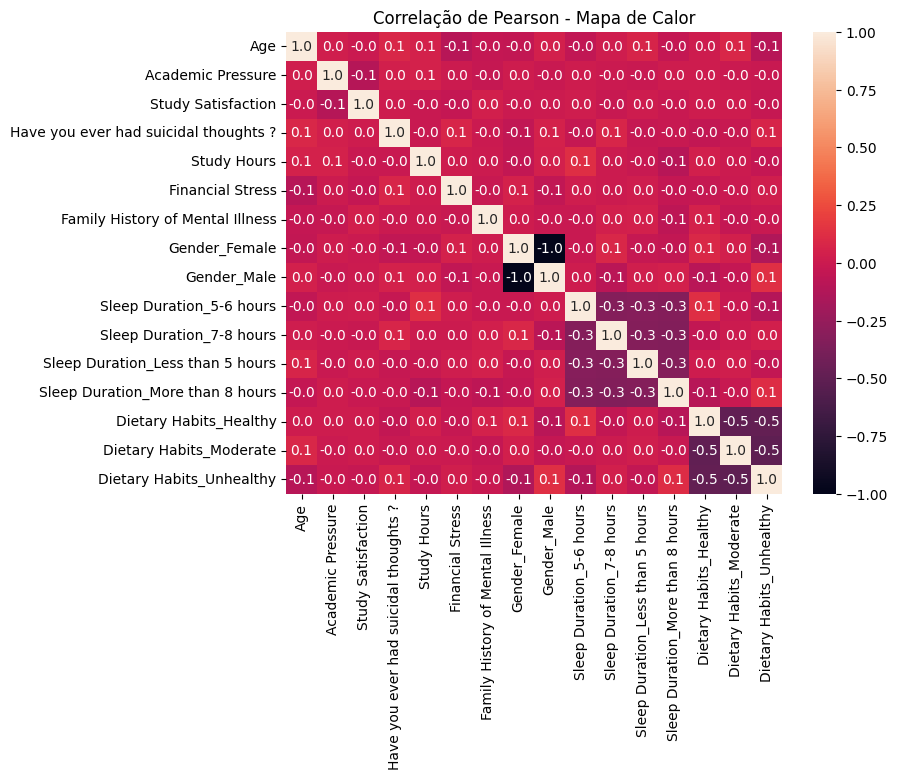

In [88]:
correlacao = X.corr(method='pearson')

plt.figure(figsize=(8, 6))  # Define o tamanho da figura
sns.heatmap(correlacao, annot=True, fmt='.1f')
plt.title('Correlação de Pearson - Mapa de Calor')
plt.savefig('correlação_heatmap.png')
plt.show()


Age - Depression False:
  Q1: 23.00, Q2: 28.00, Q3: 31.00
  Limite Inferior (LI): 11.00
  Limite Superior (LS): 43.00


Age - Depression True:
  Q1: 21.00, Q2: 25.00, Q3: 29.00
  Limite Inferior (LI): 9.00
  Limite Superior (LS): 41.00



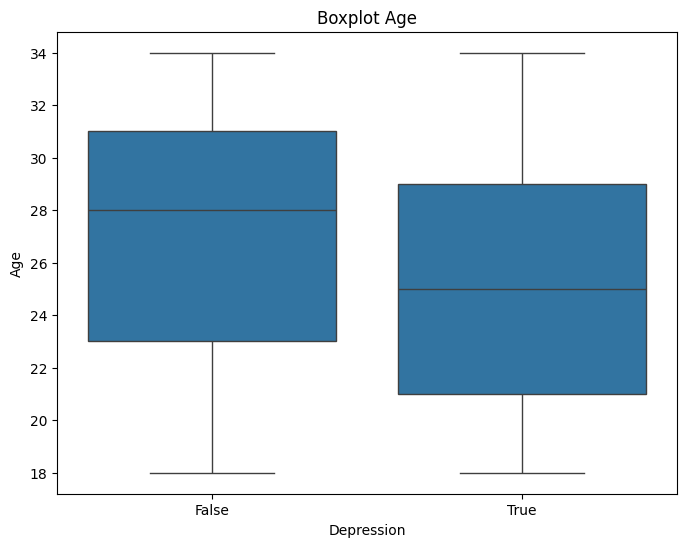


Academic Pressure - Depression False:
  Q1: 1.00, Q2: 2.00, Q3: 3.00
  Limite Inferior (LI): -2.00
  Limite Superior (LS): 6.00


Academic Pressure - Depression True:
  Q1: 3.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): 0.00
  Limite Superior (LS): 8.00



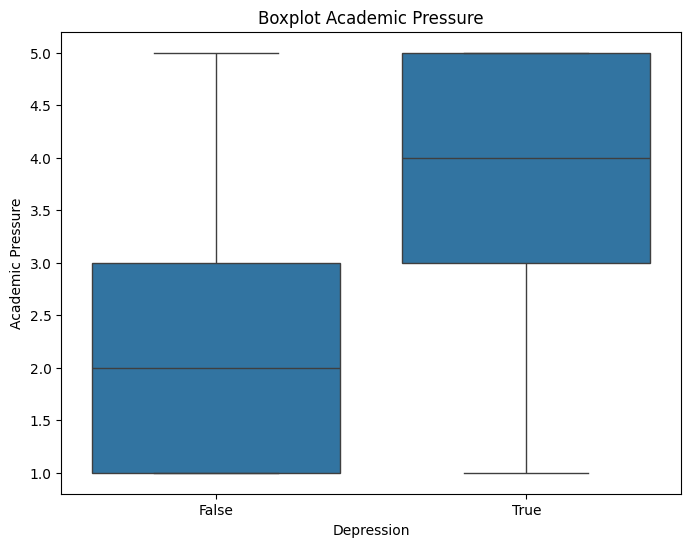


Study Satisfaction - Depression False:
  Q1: 3.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): 0.00
  Limite Superior (LS): 8.00


Study Satisfaction - Depression True:
  Q1: 1.75, Q2: 3.00, Q3: 4.00
  Limite Inferior (LI): -1.62
  Limite Superior (LS): 7.38



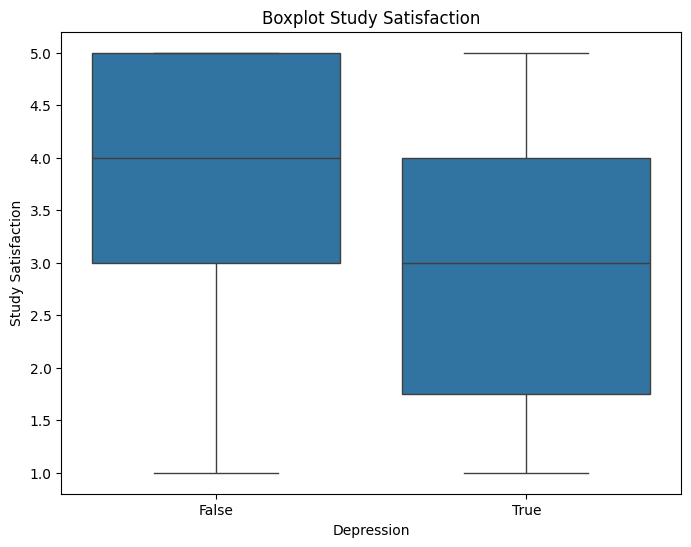


Study Hours - Depression False:
  Q1: 2.00, Q2: 5.50, Q3: 9.00
  Limite Inferior (LI): -8.50
  Limite Superior (LS): 19.50


Study Hours - Depression True:
  Q1: 5.00, Q2: 8.00, Q3: 10.00
  Limite Inferior (LI): -2.50
  Limite Superior (LS): 17.50



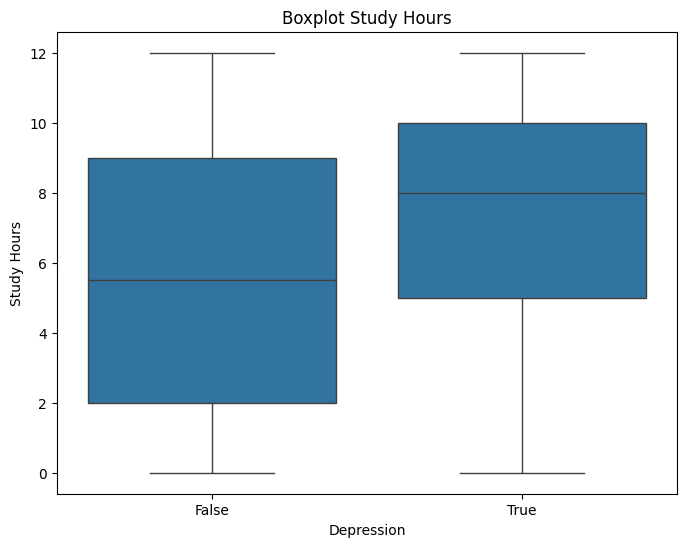


Financial Stress - Depression False:
  Q1: 1.00, Q2: 2.00, Q3: 3.75
  Limite Inferior (LI): -3.12
  Limite Superior (LS): 7.88


Financial Stress - Depression True:
  Q1: 2.00, Q2: 4.00, Q3: 5.00
  Limite Inferior (LI): -2.50
  Limite Superior (LS): 9.50



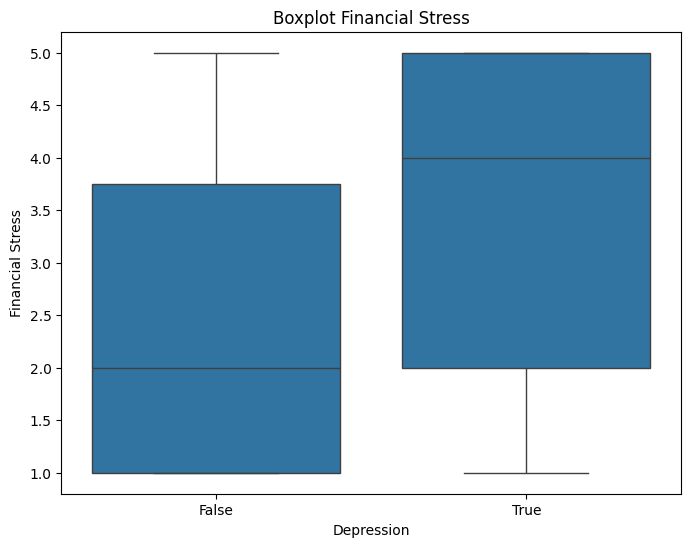

In [89]:
for feature in X[numericas]:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=y, y=feature, data=X)
    plt.title(f'Boxplot {feature}')

    for class_label in sorted(y.unique()):
        Q1 = X[y == class_label][feature].quantile(0.25)
        Q2 = X[y == class_label][feature].median()
        Q3 = X[y == class_label][feature].quantile(0.75)
        IQR = Q3 - Q1
        LI = Q1 - 1.5 * IQR
        LS = Q3 + 1.5 * IQR

        print(f"\n{feature} - Depression {class_label}:")
        print(f"  Q1: {Q1:.2f}, Q2: {Q2:.2f}, Q3: {Q3:.2f}")
        print(f"  Limite Inferior (LI): {LI:.2f}")
        print(f"  Limite Superior (LS): {LS:.2f}\n")

    plt.savefig(f'boxplot_{feature.replace("/", "_")}.png')
    plt.show()